In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

# Classification

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
 
#1. Load Data
testing = spark.read.csv("GameTest.csv", header=True, inferSchema=True)
training = spark.read.csv("GameTrain.csv", header=True, inferSchema=True)

#2. Select feature & remove missing value

testing = testing.select("Rating", "Popular", "SalesPerWeek", "Overall")
training = training.select("Rating", "Popular", "SalesPerWeek", "Overall")
testing = testing.na.drop()
training = training.na.drop()

#4. transform Data
from pyspark.sql.functions import when
#otherwise(2) = .when yg paling akhir
def process(Data):
  Data = Data.withColumn(
      "Rating",
      when (Data ["Rating"]=="Low", 0)
      .when (Data ["Rating"]=="Average", 1)
      .otherwise(2)
  )
  Data = Data.withColumn(
      "Popular",
      when (Data ["Popular"]=="No", 0)
      .otherwise(1)
  )
  Data = Data.withColumn(
      "Overall",
      when (Data ["Overall"]=="Bad", 0)
      .otherwise(1)
  )
  #5. normalize

  columns = Data.columns
  columns.remove("Overall")
  Data = VectorAssembler(inputCols=columns, outputCol="Feature Vector").transform(Data)
  Data = StandardScaler(inputCol="Feature Vector", outputCol="Feature").fit(Data).transform(Data)

  return Data

training = process(training)
testing = process(testing)

#6. model
from pyspark.ml.classification import LogisticRegression

# #seed=1 tambahan
model = LogisticRegression(featuresCol = "Feature", labelCol="Overall", maxIter = 10).fit(training)

#7. Model testing
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predict = model.transform(testing)
predict.show()

eval = BinaryClassificationEvaluator(labelCol = "Overall")

print(f'Accuracy: {eval.evaluate(predict)*100} %')

+------+-------+------------+-------+--------------+--------------------+--------------------+--------------------+----------+
|Rating|Popular|SalesPerWeek|Overall|Feature Vector|             Feature|       rawPrediction|         probability|prediction|
+------+-------+------------+-------+--------------+--------------------+--------------------+--------------------+----------+
|     1|      1|          39|      1|[1.0,1.0,39.0]|[1.34785265931084...|[-3.1275504923497...|[0.04198502137745...|       1.0|
|     2|      1|          20|      1|[2.0,1.0,20.0]|[2.69570531862169...|[-3.0428055221163...|[0.04552909789036...|       1.0|
|     0|      0|          19|      0|[0.0,0.0,19.0]|[0.0,0.0,1.597125...|[5.71622492007111...|[0.99671868698880...|       0.0|
|     2|      1|          31|      1|[2.0,1.0,31.0]|[2.69570531862169...|[-5.0479602872046...|[0.00638143572718...|       1.0|
|     1|      0|          15|      0|[1.0,0.0,15.0]|[1.34785265931084...|[3.06666793791138...|[0.95549669879457

# Exploration and Visualization

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


spark = SparkSession.builder.getOrCreate()

In [4]:
spark.read.csv("Branches.csv", header=True).createOrReplaceTempView("branch")
spark.read.csv("Games.csv", header=True).createOrReplaceTempView("game")
spark.read.csv("Genres.csv", header=True).createOrReplaceTempView("genre")
spark.read.csv("Platforms.csv", header=True).createOrReplaceTempView("platform")
spark.read.csv("Staffs.csv", header=True).createOrReplaceTempView("staff")
spark.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("transaction_headers")

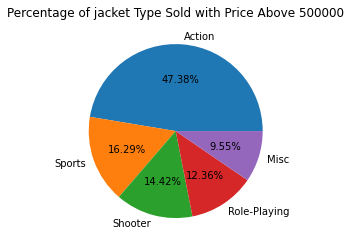

In [25]:
# a.	Show the percentage of games released by genres that is in the next 
# generation platform (“WiiU”,”PS4”,”XOne”) using pie plot.
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT count(g.gameid) as count, ge.genrename
  FROM Game g JOIN platform p on p.platformid = g.platformid 
  JOIN genre ge on ge.genreid = g.genreid
  WHERE p.platformname='WiiU' or p.platformname='PS4' or p.platformname='XOne' 
  group by g.genreid, ge.genrename
  Order by count desc
  LIMIT 5
""").toPandas()

plt.pie(data["count"], labels=data["genrename"], autopct="%.2f%%")
plt.title("Percentage of jacket Type Sold with Price Above 500000")
plt.show()

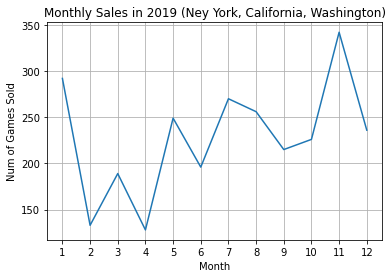

In [32]:
# b.Show the total number of games sold per month in 2019 in which the transaction is 
# done in “New York”, “California”, or “Washington” branch region using line plot.

#.show()
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT SUM(td.Quantity) as qty, MONTH(th.transactiondate) as month
  FROM transaction_details td JOIN game g
  on td.gameid = g.gameid JOIN transaction_headers th
  on th.transactionid = td.transactionid JOIN branch b
  on th.branchid = b.branchid
  WHERE year(th.transactiondate) = 2019 and (b.branchregion = 'New York' 
    or b.branchregion = 'California' or b.branchregion = 'Washington')
  group by MONTH(th.transactiondate)
  order by MONTH(th.transactiondate)

""").toPandas()

plt.plot(data["month"], data["qty"])
plt.grid()
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Num of Games Sold")
plt.title("Monthly Sales in 2019 (Ney York, California, Washington)")
plt.show()